### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [1]:
import tensorflow as tf

from qiskit import QuantumCircuit, Aer, execute
from math import asin, sqrt, ceil
from qiskit.opflow import Z, CircuitStateFn, StateFn, PauliExpectation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, ReLU

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.executing_eagerly()

True

In [3]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

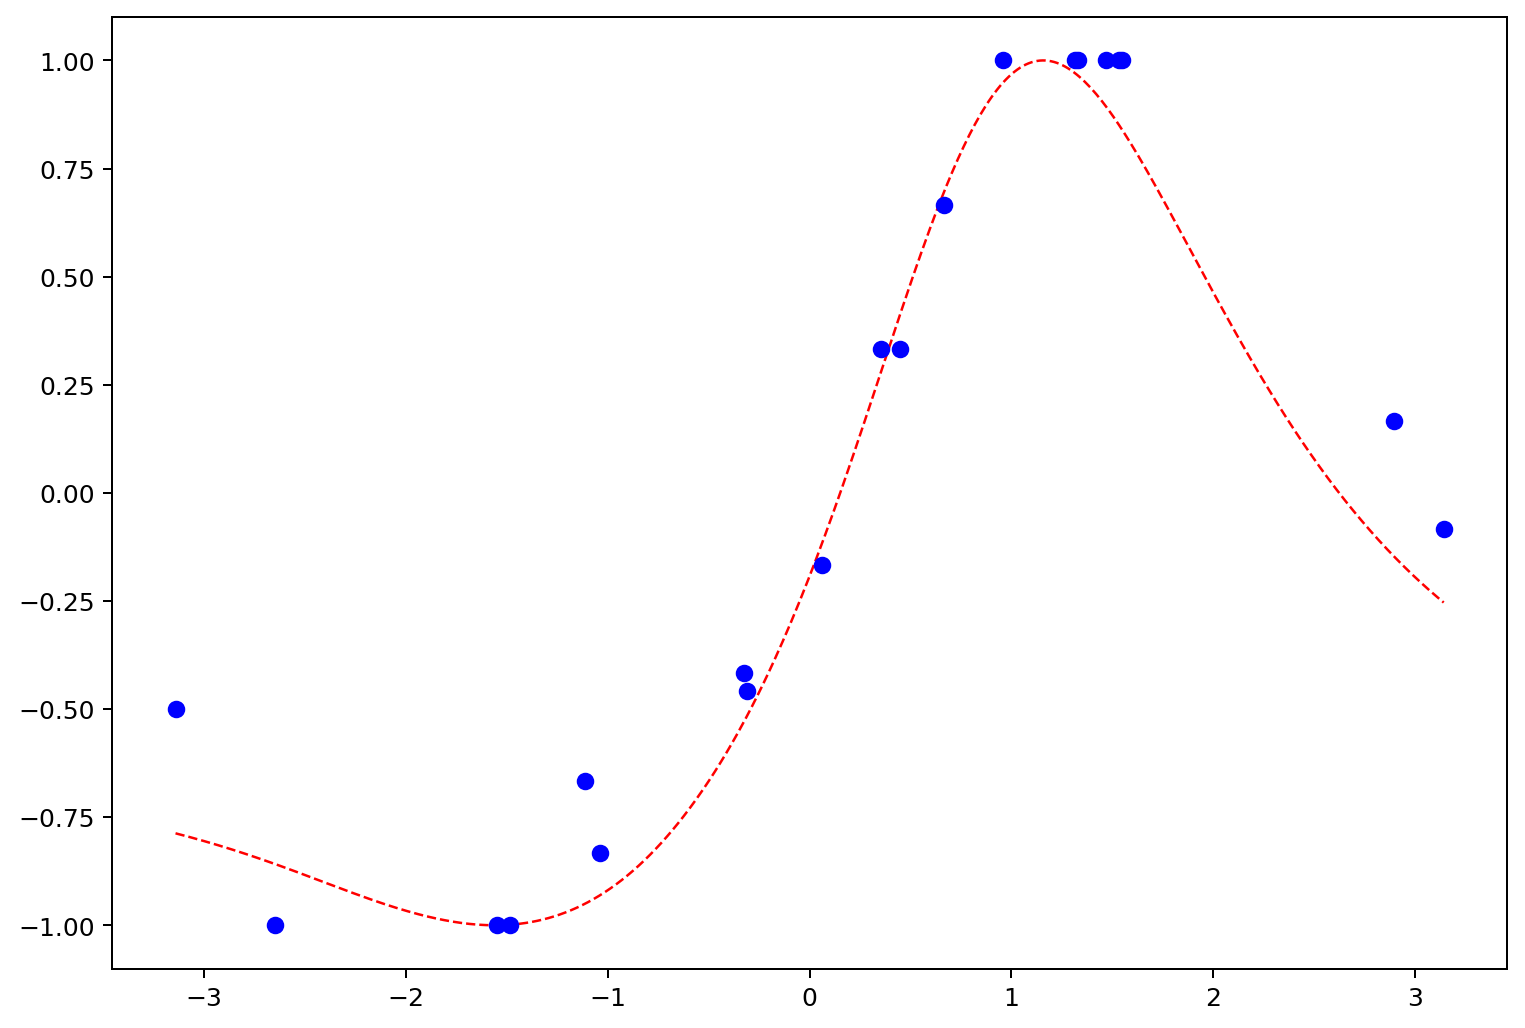

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [7]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [8]:
def quantum_layer2(initial_parameters, num_qubits):
   
    simulator = Aer.get_backend('qasm_simulator')
    shots = 1024

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)
   
        quantumCircuit.measure_all()

        job = execute(quantumCircuit, backend=simulator, shots=shots)
        result = job.result().get_counts(quantumCircuit)

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / shots
        
        # Get state expectation
        expectation_value = np.sum(states * probabilities)
        
        expectations.append(expectation_value)

    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0)
            
    return np.array(expectations)

In [9]:
def quantum_layer(initial_parameters, num_qubits):

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)

        #quantumCircuit.h(range(num_qubits))
 
        operator = Z
        for _ in range(num_qubits - 1):
            operator @= Z
          
        psi = StateFn(quantumCircuit)
        #psi = CircuitStateFn(quantumCircuit)
        #expectation_value = psi.adjoint().compose(operator).compose(psi).eval() 
        expectation_value = (~psi @ operator @ psi).eval()
        #expectation_value = PauliExpectation().convert(expectation_value).eval()

        expectations.append(expectation_value)
 
    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0j)
    
    return expectations

In [10]:
class Linear(Layer):
    
    def __init__(self, output_size, batch_size = 10, units = 1, input_dim=1, num_qubits = 1, **kwargs):
        
        super(Linear, self).__init__(**kwargs)
        
        #self.threshold = 0.1
        self.num_qubits = num_qubits
        self.output_size = output_size
        self.dense = tf.keras.layers.Dense(num_qubits, name='internal_dense')
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def build(self, input_shape): 
        self.input_size = input_shape[1]        
        self.w = self.add_weight(shape=(self.input_size, self.output_size), initializer='random_normal', trainable=True)
        super(Linear, self).build(input_shape)
        
    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return [shape_a, shape_b]
    
    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer2(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))
            
            #out_layer = tf.keras.layers.Dense(self.num_qubits, activation='relu')
            
            return tf.convert_to_tensor(final_output)
        
        #return tf.sigmoid(tf.add(tf.matmul(inputs, self.w**2), self.b))
        #x = self.dense(inputs)
        return inputs

In [11]:
n_qubits = 1

In [12]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'linear', input_shape = [1], name = "dense1"))
    layers_arr.append(Linear(output_size = n_qubits, units = 1, input_dim = n_qubits, num_qubits = n_qubits, name = "quantum1"))
    #layers_arr.append(Dense(1, activation="linear", name = "dense2"))   
    layers_arr.append(Dense(1, name ="dense3"))

    return Sequential(layers_arr)

In [13]:
model = sequential_model()

#optimizer = Adam(learning_rate=0.01)
optimizer = SGD(learning_rate=0.01)

#model.compile(loss='mse', optimizer = optimizer, metrics = ['mae', 'mse', 'acc'], run_eagerly=True)
model.compile(optimizer, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1)                 2         
_________________________________________________________________
quantum1 (Linear)            (None, 1)                 2         
_________________________________________________________________
dense3 (Dense)               (None, 1)                 2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(XX, yy, epochs = 150, batch_size=n_qubits, validation_split = 0.25)

#history = model.fit(XX, yy, epochs = 50, batch_size=n_qubits, validation_split = 0.25)

Epoch 1/150
15/15 [==============================] - 0s 24ms/step - loss: 0.2106 - accuracy: 0.2000 - val_loss: 0.4327 - val_accuracy: 0.0000e+00
Epoch 2/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2144 - accuracy: 0.2000 - val_loss: 0.4459 - val_accuracy: 0.2000
Epoch 3/150
13/15 [=========================>....] - ETA: 0s - loss: 0.1663 - accuracy: 0.1538    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2150 - accuracy: 0.1333 - val_loss: 0.4435 - val_accuracy: 0.2000
Epoch 4/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2091 - accuracy: 0.1333 - val_loss: 0.4321 - val_accuracy: 0.2000
Epoch 5/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2103 - accuracy: 0.2000 - val_loss: 0.4297 - val_accuracy: 0.2000
Epoch 6/150
 9/15 [=================>............] - ETA: 0s - loss: 0.3126 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2162 - accuracy: 0.2000 - val_loss: 0.4244 - val_accuracy: 0.4000
Epoch 7/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2037 - accuracy: 0.2000 - val_loss: 0.4356 - val_accuracy: 0.2000
Epoch 8/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2145 - accuracy: 0.2000 - val_loss: 0.4407 - val_accuracy: 0.0000e+00
Epoch 9/150
 9/15 [=================>............] - ETA: 0s - loss: 0.1507 - accuracy: 0.1111WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2099 - accuracy: 0.2000 - val_loss: 0.4616 - val_accuracy: 0.0000e+00
Epoch 10/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2101 - accuracy: 0.2000 - val_loss: 0.4603 - val_accuracy: 0.0000e+00
Epoch 11/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2133 - accuracy: 0.1333 - val_loss: 0.4208 - val_accuracy: 0.2000
Epoch 12/150
 9/15 [=================>............] - ETA: 0s - loss: 0.2629 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2103 - accuracy: 0.1333 - val_loss: 0.4082 - val_accuracy: 0.2000
Epoch 13/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2149 - accuracy: 0.2000 - val_loss: 0.4415 - val_accuracy: 0.2000
Epoch 14/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2101 - accuracy: 0.0667 - val_loss: 0.4408 - val_accuracy: 0.0000e+00
Epoch 15/150
 9/15 [=================>............] - ETA: 0s - loss: 0.1744 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.2088 - accuracy: 0.2000 - val_loss: 0.4391 - val_accuracy: 0.2000
Epoch 16/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2138 - accuracy: 0.2000 - val_loss: 0.4183 - val_accuracy: 0.4000
Epoch 17/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2124 - accuracy: 0.2000 - val_loss: 0.4302 - val_accuracy: 0.2000
Epoch 18/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.2614 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.2066 - accuracy: 0.2000 - val_loss: 0.4245 - val_accuracy: 0.2000
Epoch 19/150
15/15 [==============================] - 0s 22ms/step - loss: 0.2071 - accuracy: 0.2000 - val_loss: 0.4310 - val_accuracy: 0.2000
Epoch 20/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2118 - accuracy: 0.2000 - val_loss: 0.4223 - val_accuracy: 0.4000
Epoch 21/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.2606 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 20ms/step - loss: 0.2080 - accuracy: 0.2000 - val_loss: 0.4393 - val_accuracy: 0.2000
Epoch 22/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2107 - accuracy: 0.2000 - val_loss: 0.4234 - val_accuracy: 0.4000
Epoch 23/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2133 - accuracy: 0.2000 - val_loss: 0.4387 - val_accuracy: 0.2000
Epoch 24/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.4731 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2152 - accuracy: 0.1333 - val_loss: 0.4334 - val_accuracy: 0.2000
Epoch 25/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2098 - accuracy: 0.2000 - val_loss: 0.4357 - val_accuracy: 0.2000
Epoch 26/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2105 - accuracy: 0.2000 - val_loss: 0.4227 - val_accuracy: 0.4000
Epoch 27/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.3319 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2184 - accuracy: 0.2000 - val_loss: 0.4305 - val_accuracy: 0.4000
Epoch 28/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2110 - accuracy: 0.2000 - val_loss: 0.4356 - val_accuracy: 0.2000
Epoch 29/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2054 - accuracy: 0.2000 - val_loss: 0.4230 - val_accuracy: 0.2000
Epoch 30/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0113 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2094 - accuracy: 0.2000 - val_loss: 0.4379 - val_accuracy: 0.2000
Epoch 31/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2079 - accuracy: 0.2000 - val_loss: 0.4437 - val_accuracy: 0.2000
Epoch 32/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2148 - accuracy: 0.2000 - val_loss: 0.4283 - val_accuracy: 0.2000
Epoch 33/150
 1/15 [=>............................] - ETA: 0s - loss: 0.9445 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2075 - accuracy: 0.2000 - val_loss: 0.4372 - val_accuracy: 0.2000
Epoch 34/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2134 - accuracy: 0.2000 - val_loss: 0.4333 - val_accuracy: 0.2000
Epoch 35/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2200 - accuracy: 0.2000 - val_loss: 0.4233 - val_accuracy: 0.2000
Epoch 36/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0046 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2130 - accuracy: 0.2000 - val_loss: 0.4285 - val_accuracy: 0.2000
Epoch 37/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2188 - accuracy: 0.1333 - val_loss: 0.4032 - val_accuracy: 0.4000
Epoch 38/150
15/15 [==============================] - 0s 22ms/step - loss: 0.2143 - accuracy: 0.2000 - val_loss: 0.4368 - val_accuracy: 0.2000
Epoch 39/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0152 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2092 - accuracy: 0.2000 - val_loss: 0.4305 - val_accuracy: 0.4000
Epoch 40/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2109 - accuracy: 0.2000 - val_loss: 0.4282 - val_accuracy: 0.2000
Epoch 41/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2154 - accuracy: 0.2000 - val_loss: 0.4369 - val_accuracy: 0.4000
Epoch 42/150


15/15 [==============================] - 0s 18ms/step - loss: 0.2078 - accuracy: 0.2000 - val_loss: 0.4449 - val_accuracy: 0.2000
Epoch 43/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2113 - accuracy: 0.2000 - val_loss: 0.4389 - val_accuracy: 0.0000e+00
Epoch 44/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2117 - accuracy: 0.1333 - val_loss: 0.4372 - val_accuracy: 0.2000


Epoch 45/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2099 - accuracy: 0.2000 - val_loss: 0.4255 - val_accuracy: 0.6000
Epoch 46/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2074 - accuracy: 0.2000 - val_loss: 0.4414 - val_accuracy: 0.0000e+00
Epoch 47/150
13/15 [=========================>....] - ETA: 0s - loss: 0.2284 - accuracy: 0.1538WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.2048 - accuracy: 0.1333 - val_loss: 0.4391 - val_accuracy: 0.2000
Epoch 48/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2110 - accuracy: 0.2000 - val_loss: 0.4346 - val_accuracy: 0.4000
Epoch 49/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2097 - accuracy: 0.2000 - val_loss: 0.4354 - val_accuracy: 0.2000
Epoch 50/150
10/15 [===================>..........] - ETA: 0s - loss: 0.2634 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2151 - accuracy: 0.2000 - val_loss: 0.4454 - val_accuracy: 0.2000
Epoch 51/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2116 - accuracy: 0.2000 - val_loss: 0.4537 - val_accuracy: 0.2000
Epoch 52/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2080 - accuracy: 0.2000 - val_loss: 0.4331 - val_accuracy: 0.2000
Epoch 53/150
 9/15 [=================>............] - ETA: 0s - loss: 0.1772 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2098 - accuracy: 0.2000 - val_loss: 0.4217 - val_accuracy: 0.2000
Epoch 54/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2121 - accuracy: 0.2000 - val_loss: 0.4311 - val_accuracy: 0.2000
Epoch 55/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2058 - accuracy: 0.2000 - val_loss: 0.4349 - val_accuracy: 0.2000
Epoch 56/150
 9/15 [=================>............] - ETA: 0s - loss: 0.1870 - accuracy: 0.1111    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2070 - accuracy: 0.2000 - val_loss: 0.4293 - val_accuracy: 0.2000
Epoch 57/150
15/15 [==============================] - 0s 23ms/step - loss: 0.2160 - accuracy: 0.2000 - val_loss: 0.4353 - val_accuracy: 0.2000
Epoch 58/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2164 - accuracy: 0.2000 - val_loss: 0.4482 - val_accuracy: 0.2000
Epoch 59/150
 9/15 [=================>............] - ETA: 0s - loss: 0.1755 - accuracy: 0.1111    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2082 - accuracy: 0.2000 - val_loss: 0.4386 - val_accuracy: 0.2000
Epoch 60/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2096 - accuracy: 0.2000 - val_loss: 0.4520 - val_accuracy: 0.2000
Epoch 61/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2154 - accuracy: 0.2000 - val_loss: 0.4459 - val_accuracy: 0.0000e+00
Epoch 62/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.4937 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2117 - accuracy: 0.1333 - val_loss: 0.4211 - val_accuracy: 0.2000
Epoch 63/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2122 - accuracy: 0.2000 - val_loss: 0.4440 - val_accuracy: 0.2000
Epoch 64/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2121 - accuracy: 0.2000 - val_loss: 0.4241 - val_accuracy: 0.4000
Epoch 65/150
 6/15 [===========>..................] - ETA: 0s - loss: 0.0675 - accuracy: 0.3333WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.2042 - accuracy: 0.2000 - val_loss: 0.4383 - val_accuracy: 0.0000e+00
Epoch 66/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2117 - accuracy: 0.2000 - val_loss: 0.4516 - val_accuracy: 0.0000e+00
Epoch 67/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2122 - accuracy: 0.2000 - val_loss: 0.4509 - val_accuracy: 0.0000e+00
Epoch 68/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.0159 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2079 - accuracy: 0.2000 - val_loss: 0.4381 - val_accuracy: 0.2000
Epoch 69/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2107 - accuracy: 0.2000 - val_loss: 0.4415 - val_accuracy: 0.4000
Epoch 70/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2064 - accuracy: 0.2000 - val_loss: 0.4399 - val_accuracy: 0.4000
Epoch 71/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0900 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2151 - accuracy: 0.2000 - val_loss: 0.4435 - val_accuracy: 0.2000
Epoch 72/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2088 - accuracy: 0.2000 - val_loss: 0.4436 - val_accuracy: 0.2000
Epoch 73/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2074 - accuracy: 0.2000 - val_loss: 0.4470 - val_accuracy: 0.2000
Epoch 74/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0174 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2111 - accuracy: 0.2000 - val_loss: 0.4412 - val_accuracy: 0.2000
Epoch 75/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2056 - accuracy: 0.1333 - val_loss: 0.4258 - val_accuracy: 0.2000
Epoch 76/150
15/15 [==============================] - 0s 22ms/step - loss: 0.2177 - accuracy: 0.2000 - val_loss: 0.4526 - val_accuracy: 0.2000
Epoch 77/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0168 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.2094 - accuracy: 0.2000 - val_loss: 0.4252 - val_accuracy: 0.2000
Epoch 78/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2178 - accuracy: 0.2000 - val_loss: 0.4379 - val_accuracy: 0.2000
Epoch 79/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2089 - accuracy: 0.2000 - val_loss: 0.4612 - val_accuracy: 0.0000e+00
Epoch 80/150
 1/15 [=>............................] - ETA: 0s - loss: 0.2118 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 20ms/step - loss: 0.2093 - accuracy: 0.2000 - val_loss: 0.4583 - val_accuracy: 0.0000e+00
Epoch 81/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2181 - accuracy: 0.2000 - val_loss: 0.4446 - val_accuracy: 0.2000
Epoch 82/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2113 - accuracy: 0.2000 - val_loss: 0.4573 - val_accuracy: 0.2000
Epoch 83/150


15/15 [==============================] - 0s 18ms/step - loss: 0.2126 - accuracy: 0.2000 - val_loss: 0.4661 - val_accuracy: 0.0000e+00
Epoch 84/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2231 - accuracy: 0.2000 - val_loss: 0.4743 - val_accuracy: 0.0000e+00
Epoch 85/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2146 - accuracy: 0.2000 - val_loss: 0.4422 - val_accuracy: 0.0000e+00


Epoch 86/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2110 - accuracy: 0.2000 - val_loss: 0.4423 - val_accuracy: 0.2000
Epoch 87/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2035 - accuracy: 0.2000 - val_loss: 0.4395 - val_accuracy: 0.2000
Epoch 88/150
13/15 [=========================>....] - ETA: 0s - loss: 0.2420 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2128 - accuracy: 0.2000 - val_loss: 0.4389 - val_accuracy: 0.4000
Epoch 89/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2067 - accuracy: 0.2000 - val_loss: 0.4317 - val_accuracy: 0.2000
Epoch 90/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2169 - accuracy: 0.2000 - val_loss: 0.4309 - val_accuracy: 0.2000
Epoch 91/150
13/15 [=========================>....] - ETA: 0s - loss: 0.2417 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2117 - accuracy: 0.2000 - val_loss: 0.4376 - val_accuracy: 0.2000
Epoch 92/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2156 - accuracy: 0.2000 - val_loss: 0.4373 - val_accuracy: 0.2000
Epoch 93/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2150 - accuracy: 0.2000 - val_loss: 0.4417 - val_accuracy: 0.2000
Epoch 94/150
 9/15 [=================>............] - ETA: 0s - loss: 0.1943 - accuracy: 0.1111    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.2151 - accuracy: 0.2000 - val_loss: 0.4449 - val_accuracy: 0.2000
Epoch 95/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2106 - accuracy: 0.2000 - val_loss: 0.4465 - val_accuracy: 0.2000
Epoch 96/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2148 - accuracy: 0.2000 - val_loss: 0.4577 - val_accuracy: 0.2000
Epoch 97/150
 9/15 [=================>............] - ETA: 0s - loss: 0.0545 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2089 - accuracy: 0.2000 - val_loss: 0.4420 - val_accuracy: 0.2000
Epoch 98/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2116 - accuracy: 0.2000 - val_loss: 0.4472 - val_accuracy: 0.2000
Epoch 99/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2146 - accuracy: 0.2000 - val_loss: 0.4435 - val_accuracy: 0.2000
Epoch 100/150
 9/15 [=================>............] - ETA: 0s - loss: 0.3185 - accuracy: 0.1111    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2126 - accuracy: 0.1333 - val_loss: 0.4288 - val_accuracy: 0.6000
Epoch 101/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2122 - accuracy: 0.2000 - val_loss: 0.4238 - val_accuracy: 0.2000
Epoch 102/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2115 - accuracy: 0.2000 - val_loss: 0.4387 - val_accuracy: 0.0000e+00
Epoch 103/150
 9/15 [=================>............] - ETA: 0s - loss: 0.2980 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2144 - accuracy: 0.1333 - val_loss: 0.4248 - val_accuracy: 0.4000
Epoch 104/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2120 - accuracy: 0.2000 - val_loss: 0.4337 - val_accuracy: 0.2000
Epoch 105/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2102 - accuracy: 0.2000 - val_loss: 0.4219 - val_accuracy: 0.2000
Epoch 106/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.0207 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2092 - accuracy: 0.2000 - val_loss: 0.4394 - val_accuracy: 0.2000
Epoch 107/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2072 - accuracy: 0.2000 - val_loss: 0.4322 - val_accuracy: 0.2000
Epoch 108/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2116 - accuracy: 0.2000 - val_loss: 0.4274 - val_accuracy: 0.2000
Epoch 109/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.2735 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2019 - accuracy: 0.2000 - val_loss: 0.4391 - val_accuracy: 0.2000
Epoch 110/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2162 - accuracy: 0.2000 - val_loss: 0.4507 - val_accuracy: 0.4000
Epoch 111/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2124 - accuracy: 0.2000 - val_loss: 0.4313 - val_accuracy: 0.4000
Epoch 112/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.0123 - accuracy: 0.0000e+00    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2114 - accuracy: 0.2000 - val_loss: 0.4302 - val_accuracy: 0.2000
Epoch 113/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2083 - accuracy: 0.2000 - val_loss: 0.4205 - val_accuracy: 0.4000
Epoch 114/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2182 - accuracy: 0.2000 - val_loss: 0.4369 - val_accuracy: 0.2000
Epoch 115/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.3590 - accuracy: 0.4000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2145 - accuracy: 0.2000 - val_loss: 0.4300 - val_accuracy: 0.4000
Epoch 116/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2030 - accuracy: 0.1333 - val_loss: 0.4187 - val_accuracy: 0.4000
Epoch 117/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2137 - accuracy: 0.2000 - val_loss: 0.4290 - val_accuracy: 0.4000
Epoch 118/150
 1/15 [=>............................] - ETA: 0s - loss: 0.1809 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2221 - accuracy: 0.2000 - val_loss: 0.4202 - val_accuracy: 0.4000
Epoch 119/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2124 - accuracy: 0.2000 - val_loss: 0.4391 - val_accuracy: 0.2000
Epoch 120/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2154 - accuracy: 0.2000 - val_loss: 0.4235 - val_accuracy: 0.4000
Epoch 121/150
 1/15 [=>............................] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2191 - accuracy: 0.2000 - val_loss: 0.4516 - val_accuracy: 0.2000
Epoch 122/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2175 - accuracy: 0.2000 - val_loss: 0.4461 - val_accuracy: 0.2000
Epoch 123/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2117 - accuracy: 0.2000 - val_loss: 0.4284 - val_accuracy: 0.4000
Epoch 124/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0062 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2079 - accuracy: 0.2000 - val_loss: 0.4451 - val_accuracy: 0.0000e+00
Epoch 125/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2139 - accuracy: 0.2000 - val_loss: 0.4472 - val_accuracy: 0.2000
Epoch 126/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2114 - accuracy: 0.1333 - val_loss: 0.4245 - val_accuracy: 0.2000
Epoch 127/150
 1/15 [=>............................] - ETA: 0s - loss: 0.0199 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2085 - accuracy: 0.2000 - val_loss: 0.4192 - val_accuracy: 0.4000
Epoch 128/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2135 - accuracy: 0.2000 - val_loss: 0.4413 - val_accuracy: 0.4000
Epoch 129/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2177 - accuracy: 0.2000 - val_loss: 0.4277 - val_accuracy: 0.2000
Epoch 130/150


15/15 [==============================] - 0s 18ms/step - loss: 0.2136 - accuracy: 0.2000 - val_loss: 0.4310 - val_accuracy: 0.4000
Epoch 131/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2170 - accuracy: 0.2000 - val_loss: 0.4438 - val_accuracy: 0.2000
Epoch 132/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2101 - accuracy: 0.2000 - val_loss: 0.4517 - val_accuracy: 0.0000e+00


Epoch 133/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2125 - accuracy: 0.2000 - val_loss: 0.4617 - val_accuracy: 0.0000e+00
Epoch 134/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2106 - accuracy: 0.2000 - val_loss: 0.4548 - val_accuracy: 0.2000
Epoch 135/150
13/15 [=========================>....] - ETA: 0s - loss: 0.2394 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.2097 - accuracy: 0.2000 - val_loss: 0.4315 - val_accuracy: 0.2000
Epoch 136/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2056 - accuracy: 0.2000 - val_loss: 0.4283 - val_accuracy: 0.2000
Epoch 137/150
15/15 [==============================] - 0s 20ms/step - loss: 0.2132 - accuracy: 0.2000 - val_loss: 0.4395 - val_accuracy: 0.2000
Epoch 138/150
13/15 [=========================>....] - ETA: 0s - loss: 0.2506 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 20ms/step - loss: 0.2191 - accuracy: 0.2000 - val_loss: 0.4301 - val_accuracy: 0.2000
Epoch 139/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2134 - accuracy: 0.2000 - val_loss: 0.4217 - val_accuracy: 0.6000
Epoch 140/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2137 - accuracy: 0.2000 - val_loss: 0.4533 - val_accuracy: 0.2000
Epoch 141/150
 9/15 [=================>............] - ETA: 0s - loss: 0.3130 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.2131 - accuracy: 0.2000 - val_loss: 0.4207 - val_accuracy: 0.2000
Epoch 142/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2107 - accuracy: 0.2000 - val_loss: 0.4232 - val_accuracy: 0.4000
Epoch 143/150
15/15 [==============================] - 0s 19ms/step - loss: 0.2051 - accuracy: 0.2000 - val_loss: 0.4210 - val_accuracy: 0.2000
Epoch 144/150
 9/15 [=================>............] - ETA: 0s - loss: 0.2898 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 24ms/step - loss: 0.2008 - accuracy: 0.2000 - val_loss: 0.4198 - val_accuracy: 0.4000
Epoch 145/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2043 - accuracy: 0.2000 - val_loss: 0.4096 - val_accuracy: 0.4000
Epoch 146/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2119 - accuracy: 0.2000 - val_loss: 0.4064 - val_accuracy: 0.4000
Epoch 147/150
 9/15 [=================>............] - ETA: 0s - loss: 0.3011 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2056 - accuracy: 0.2000 - val_loss: 0.4076 - val_accuracy: 0.4000
Epoch 148/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2152 - accuracy: 0.2000 - val_loss: 0.4238 - val_accuracy: 0.2000
Epoch 149/150
15/15 [==============================] - 0s 18ms/step - loss: 0.2109 - accuracy: 0.2000 - val_loss: 0.4225 - val_accuracy: 0.4000
Epoch 150/150
 5/15 [=========>....................] - ETA: 0s - loss: 0.0836 - accuracy: 0.4000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.2151 - accuracy: 0.2000 - val_loss: 0.4350 - val_accuracy: 0.2000


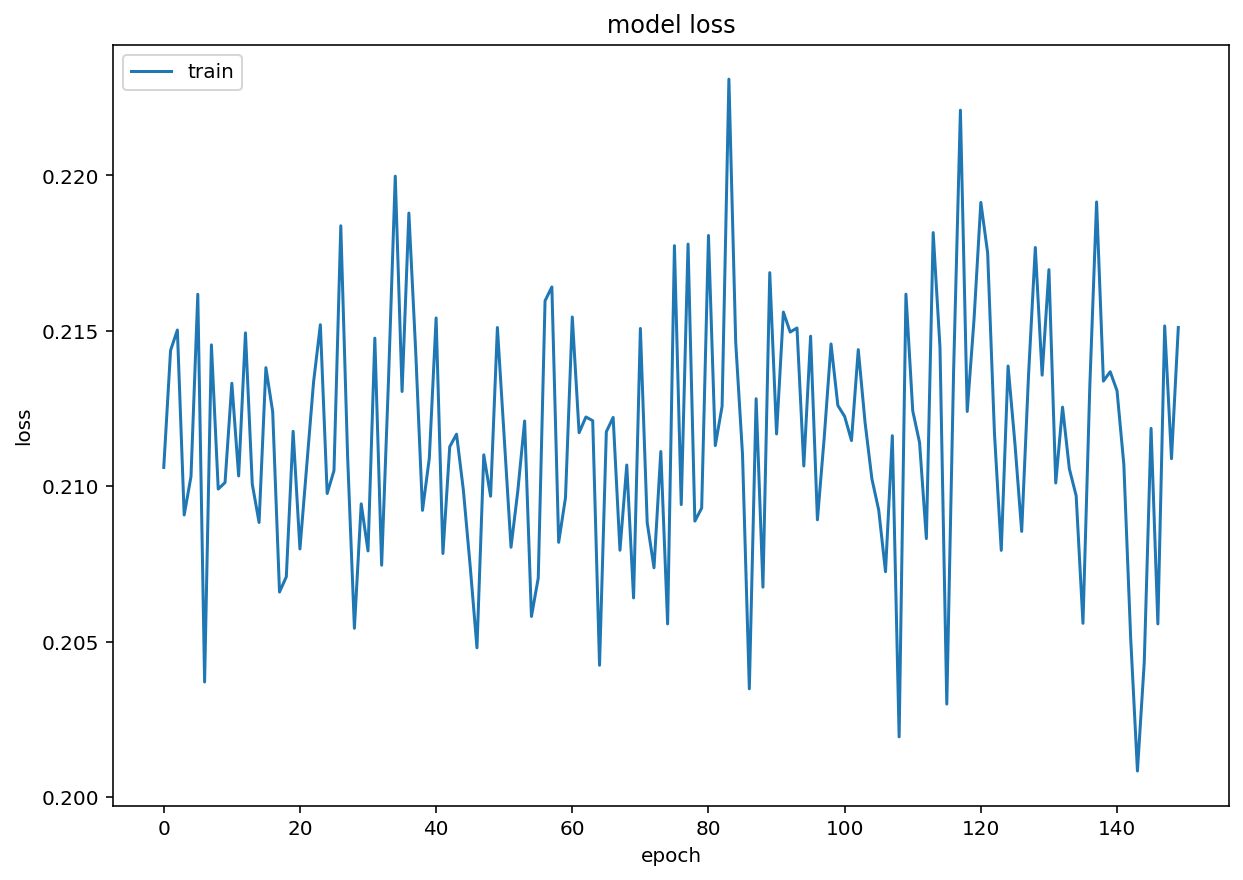

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
def split_batch_predict(data, num_qubits, model):
    
    splitted_X = None

    if num_qubits > 1:
        num_sections = ceil(X_.shape[0] / num_qubits)
        splitted_X = np.array_split(data.flatten(), num_sections)
    else:
        splitted_X = data

    y_prediction = []

    for arr in splitted_X:
        pred = model.predict(arr)
        y_prediction.append(pred.tolist())
    
    return np.array(y_prediction)

In [26]:
y_predict = split_batch_predict(X_, n_qubits, model)

In [27]:
y_predict_smooth = smooth(y_predict)

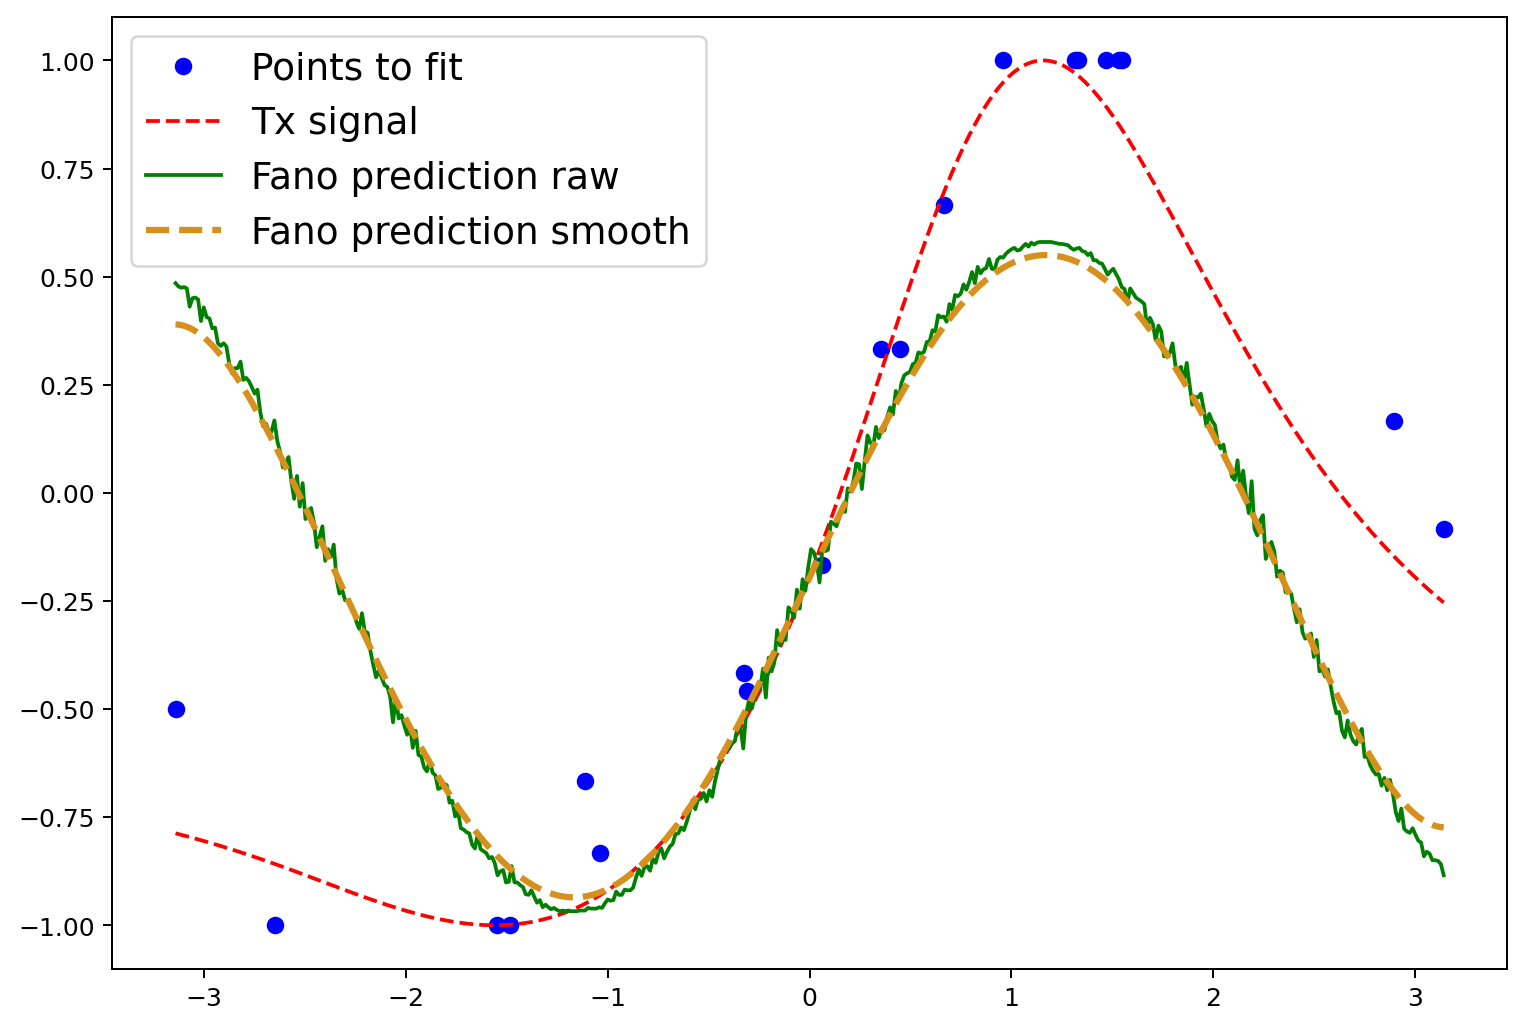

In [28]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict.flatten(), "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth.flatten(), "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [29]:
print("Score: %.10f" % r2_score(y_, y_predict.flatten()))

Score: 0.5171175488


In [22]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright